In [135]:
import numpy as np
import networkx as nx
import math
import random
#from sklearn.cluster import KMeans
from typing import List
import matplotlib
import colorsys

WAREHOUSE_COLOR = 'magenta'
def get_truck_colors(n_trucks : int) -> List[str]:
    cmap = matplotlib.colormaps['Spectral']
    #color_rgba  = cmap(np.linspace(0.0,1.0,n_trucks))
    color_rgba = getDistinctColors(n_trucks)
    
    colors_hex = []
    for c in color_rgba:
        colors_hex.append('#{:02x}{:02x}{:02x}'.format(*(c)))
        #colors_hex.append('#{:02x}{:02x}{:02x}'.format(*(c*255).astype(int)))
    return colors_hex


def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (int(255*r), int(255*g), int(255*b)) 
 
def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return (HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n)) 

class VRP:
    def __init__(self,map_width : float , map_height : float, n_clients : int, n_trucks : int, truck_capacity : float = 50 ,warehouse_loc : tuple[float,float] = None) :
        self.n_clients = n_clients
        self.n_trucks = n_trucks
        self.truck_capacity = truck_capacity
        self.POPULATION_SIZE = 100
        if warehouse_loc is None:
            self.warehouse_loc = (random.random()*map_width,random.random()*map_height)
        else:
            self.warehouse_loc = warehouse_loc
        self.population = np.zeros((self.POPULATION_SIZE,n_clients),dtype=int)
        self.capacities = np.zeros((self.POPULATION_SIZE,n_clients),dtype=float)
        #GRAPH
        client_locations_x = np.random.random((n_clients,1))*map_width
        client_locations_y = np.random.random((n_clients,1))*map_height
        self.client_locations = np.hstack([client_locations_x,client_locations_y])
        self.graph = nx.Graph()
        for i,(x,y) in enumerate(self.client_locations):
            self.graph.add_node(i,pos=(x,y))
        self.graph.add_node(-1,pos=self.warehouse_loc)
        
        for i,(x,y) in enumerate(self.client_locations):
            self.graph.add_edge(i,-1,weight = math.sqrt((self.warehouse_loc[0]-x)**2+(self.warehouse_loc[1]-y)**2),color='r')

            
        #TODO: renderlo piu efficiente con n*(n-1)/2
        for i,(x,y) in enumerate(self.client_locations):
            for j,(xx,yy) in enumerate(self.client_locations):
                if i!= j:
                    self.graph.add_edge(i,j,weight = math.sqrt((xx-x)**2+(yy-y)**2))
                    
    def draw_problem(self, show_edges : bool = False):
        raise Exception("change")
        node_color = []
        for node in self.graph:
            node_color.append("yellow" if node == -1 else "coral")
        if show_edges:
            nx.draw(self.graph, nx.get_node_attributes(self.graph, 'pos'), with_labels=True, node_size=150,node_color = node_color)
        else:
            nx.draw_networkx_nodes(self.graph, nx.get_node_attributes(self.graph, 'pos'), node_size=100,node_color = node_color)
            
    def init_random_population(self):
        #self.population = np.random.randint(0, self.n_trucks, size=(self.POPULATION_SIZE,self.n_clients))
        array =  np.arange(0,self.n_clients)
        self.population = np.tile(array, (self.POPULATION_SIZE, 1)) 
        #print(self.population)
        #self.population[np.arange(len(self.population))[:,None], np.random.randn(*self.population.shape).argsort(axis=1)]
        self.population = np.apply_along_axis(np.random.permutation, axis=1, arr=self.population)
        self.capacities = np.random.random((self.POPULATION_SIZE,self.n_clients)) * self.truck_capacity/5
        #print("aaaaaaaaaaaaa")
        #print(self.population)
    def fitness_function(self,index):
        #USES A GREEDY APPROACH DESCRIBED IN https://www.researchgate.net/publication/268043232_Comparison_of_eight_evolutionary_crossover_operators_for_the_vehicle_routing_problem 
        curr_chromosome = self.population[index]
        routes = []
        curr_route = ["B",curr_chromosome[0]]
        curr_truck = 0
        total_distance = self.graph.edges[(-1,curr_chromosome[0])]['weight']
        capacity_curr = self.capacities[index][curr_chromosome[0]]
        for i in range(1,len(curr_chromosome)):
            capacity_curr += self.capacities[index][curr_chromosome[i]]
            
            #print(capacity_curr)
            if capacity_curr > self.truck_capacity:
                #ended route
                print(f"Ending route: truck number {curr_truck} filled with {capacity_curr-self.capacities[index][curr_chromosome[i]]} kg")
                #capacity_curr = 0
                curr_truck+=1
                total_distance+=self.graph.edges[(curr_chromosome[i-1],-1)]['weight']
                curr_route.append("B")
                routes.append(curr_route)
                curr_route = ["B",curr_chromosome[i]]
                total_distance+=self.graph.edges[(-1,curr_chromosome[i])]['weight']
                capacity_curr = self.capacities[index][curr_chromosome[i]]
            else:
                curr_route.append(curr_chromosome[i])
                total_distance+=self.graph.edges[(curr_chromosome[i-1],curr_chromosome[i])]['weight']
        curr_route.append("B")
        routes.append(curr_route)
        total_distance+=self.graph.edges[(len(curr_chromosome)-1,-1)]['weight']
        curr_truck += 1
        print(f"total distance: {total_distance}")
        print(f"number of used trucks: {curr_truck}")
        if curr_truck > self.n_trucks:
            raise Exception("Numero di camion nella soluzione superiore al consentito")
        return total_distance, routes
                
    def draw_chromosome_paths(self,chromosome_index : int = 0):
        _,routes = self.fitness_function(chromosome_index)
        #FORSE ANDREBBE N_TRUCKS AL POSTO DI LEN(ROUTES
        colors = get_truck_colors(len(routes))
        colored_graph = nx.Graph()
        colored_graph.add_node("B",pos=self.warehouse_loc,color=WAREHOUSE_COLOR)

        positions = nx.get_node_attributes(self.graph,'pos')
        for truck, route in enumerate(routes):
            for client_index, client in enumerate(route):
                if client != 'B':
                    colored_graph.add_node(client,pos=positions[client],color = colors[truck])
                if client_index != 0:
                    pass
                    colored_graph.add_edge(route[client_index-1],client,color = colors[truck])
    
        nx.draw(colored_graph,nx.get_node_attributes(colored_graph,'pos'),
                node_color=nx.get_node_attributes(colored_graph,'color').values(),
                edge_color=nx.get_edge_attributes(colored_graph,'color').values()
                ,with_labels=True)
            


[25  6 31 16 30 34 14 10 11  3 20 48 28 39 18 12 45 26 21 17 47  4  7 49
 29 38 44  9 13 41 24 33 19 22 42 37 23  1 27 40  2  0 36 43 35  5 46 15
 32  8]
Ending route: truck number 0 filled with 46.3235673178084 kg
Ending route: truck number 1 filled with 47.62014222908788 kg
Ending route: truck number 2 filled with 48.014446050014634 kg
Ending route: truck number 3 filled with 45.645320073693036 kg
total distance: 6189.8512573021
number of used trucks: 5
[['B', 25, 6, 31, 16, 30, 34, 14, 10, 11, 3, 'B'], ['B', 20, 48, 28, 39, 18, 12, 45, 26, 21, 17, 47, 4, 'B'], ['B', 7, 49, 29, 38, 44, 9, 13, 41, 24, 33, 19, 22, 'B'], ['B', 42, 37, 23, 1, 27, 40, 2, 0, 36, 'B'], ['B', 43, 35, 5, 46, 15, 32, 8, 'B']]
Ending route: truck number 0 filled with 46.3235673178084 kg
Ending route: truck number 1 filled with 47.62014222908788 kg
Ending route: truck number 2 filled with 48.014446050014634 kg
Ending route: truck number 3 filled with 45.645320073693036 kg
total distance: 6189.8512573021
number o

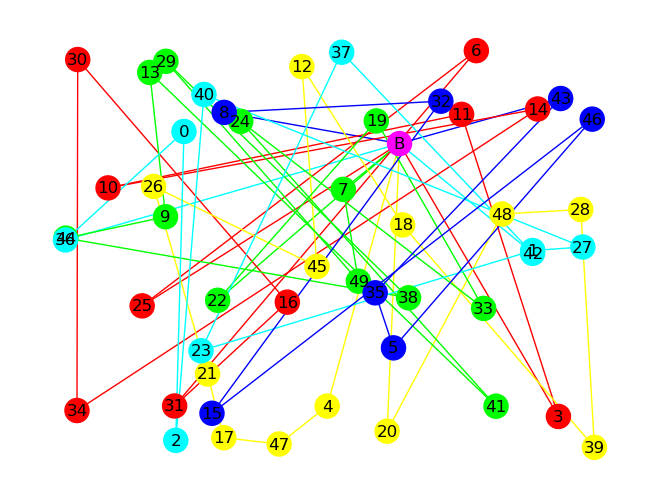

In [136]:
seed = 5
np.random.seed(seed)
random.seed(seed)
vrp = VRP(200,200,50,8)
vrp.init_random_population()
print(vrp.population[0])
distance,routes = vrp.fitness_function(0)
print(routes)
vrp.draw_chromosome_paths()
#vrp.capacities[0]

In [123]:
print(*(255,0,0))

255 0 0


array([0.82272324, 4.59584057, 3.06463468, 1.        , 0.56978727,
       4.18607275, 4.58431424, 7.25006076, 5.74287575, 6.67212337,
       7.77049286, 8.62202974, 3.13875497, 5.38022705, 8.40108078,
       9.89451131, 8.89519311, 3.71467263, 1.95166517, 4.89392537,
       7.41641452, 4.92569071, 4.83180863, 8.38230421, 3.61403779,
       8.59794675, 4.06804801, 3.28233106, 4.53989911, 7.62446959,
       1.26002028, 1.96419216, 9.51444826, 1.75491627, 5.67727318,
       5.79314467, 4.89624462, 6.44745249, 2.29826726, 5.52662268,
       3.72173255, 6.6166726 , 1.41223543, 5.70877417, 1.85270355,
       2.78643063, 2.187098  , 1.8283778 , 8.25710952, 2.85707568])

In [76]:
vrp.capacities[0][3]=1
vrp.fitness_function(0)
a = vrp.graph.edges[(-1,0)]['weight']*2
a
b= vrp.graph.edges[(-1,1)]['weight'] +vrp.graph.edges[(1,2)]['weight'] +vrp.graph.edges[(2,-1)]['weight']
b
c = vrp.graph.edges[(-1,3)]['weight']*2
c
a+b+c

Ending route: truck number 0 filled with 39.696531088435066 kg
Ending route: truck number 1 filled with 43.694695351962984 kg
Ending route: truck number 2 filled with 41.90858063351081 kg
Ending route: truck number 3 filled with 38.406295553502844 kg
Ending route: truck number 4 filled with 47.103308697080706 kg
Ending route: truck number 5 filled with 49.74689752385468 kg
Ending route: truck number 6 filled with 43.85915787615736 kg
Ending route: truck number 7 filled with 46.70247920292772 kg
Ending route: truck number 8 filled with 39.49256344680498 kg
Ending route: truck number 9 filled with 44.607578253990425 kg
Ending route: truck number 10 filled with 45.06038841808062 kg
Ending route: truck number 11 filled with 48.924332933777514 kg
Ending route: truck number 12 filled with 47.73214900683785 kg
Ending route: truck number 13 filled with 42.42996908958217 kg
Ending route: truck number 14 filled with 42.36976389303656 kg
Ending route: truck number 15 filled with 34.93027903131236

(27049.25113886217,
 [['B', 103, 33, 188, 194, 'B'],
  ['B', 138, 154, 39, 152, 3, 'B'],
  ['B', 169, 92, 185, 164, 'B'],
  ['B', 58, 66, 78, 'B'],
  ['B', 72, 187, 181, 175, 36, 114, 'B'],
  ['B', 168, 65, 54, 22, 81, 130, 'B'],
  ['B', 42, 87, 157, 93, 193, 147, 'B'],
  ['B', 67, 21, 80, 25, 105, 10, 109, 88, 'B'],
  ['B', 134, 155, 180, 159, 198, 9, 'B'],
  ['B', 1, 117, 94, 149, 50, 95, 'B'],
  ['B', 113, 34, 45, 120, 'B'],
  ['B', 148, 47, 142, 12, 97, 170, 'B'],
  ['B', 115, 197, 119, 151, 63, 40, 'B'],
  ['B', 77, 49, 59, 118, 171, 'B'],
  ['B', 101, 7, 182, 23, 158, 'B'],
  ['B', 71, 86, 156, 'B'],
  ['B', 11, 102, 96, 'B'],
  ['B', 15, 123, 53, 124, 30, 'B'],
  ['B', 14, 13, 48, 106, 'B'],
  ['B', 17, 167, 19, 133, 174, 173, 'B'],
  ['B', 100, 160, 84, 79, 20, 46, 128, 178, 'B'],
  ['B', 31, 163, 43, 129, 5, 37, 32, 55, 'B'],
  ['B', 172, 196, 62, 195, 91, 'B'],
  ['B', 76, 2, 0, 161, 199, 'B'],
  ['B', 126, 60, 57, 153, 125, 'B'],
  ['B', 166, 137, 89, 90, 107, 'B'],
  ['B', 

268.5903149054003

142.78387965009966

349.797698178117

761.1718927336169

TypeError: 'generator' object is not callable